<a href="https://colab.research.google.com/github/Richard-Shimada/Project-2/blob/main/Project_2_Part_3_RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import (ColumnTransformer, make_column_selector,
                             make_column_transformer)
from  matplotlib.ticker import PercentFormatter
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')


from google.colab import drive
drive.mount('/content/drive')

#https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

base_df = pd.read_csv('/content/drive/MyDrive/Coding Dojo 2022/07 Week 7: Classification Models/heart-failure-data.csv')
df = base_df.copy()
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
#No duplicate values
df.duplicated().sum()

0

In [ ]:
#No missing values
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
#Checking for any odd values in categorical columns, none found!
print(df['Sex'].unique())
print(df['ChestPainType'].unique())
print(df['FastingBS'].unique())
print(df['RestingECG'].unique())
print(df['ExerciseAngina'].unique())
print(df['ST_Slope'].unique())
print(df['HeartDisease'].unique())



['M' 'F']
['ATA' 'NAP' 'ASY' 'TA']
[0 1]
['Normal' 'ST' 'LVH']
['N' 'Y']
['Up' 'Flat' 'Down']
[0 1]


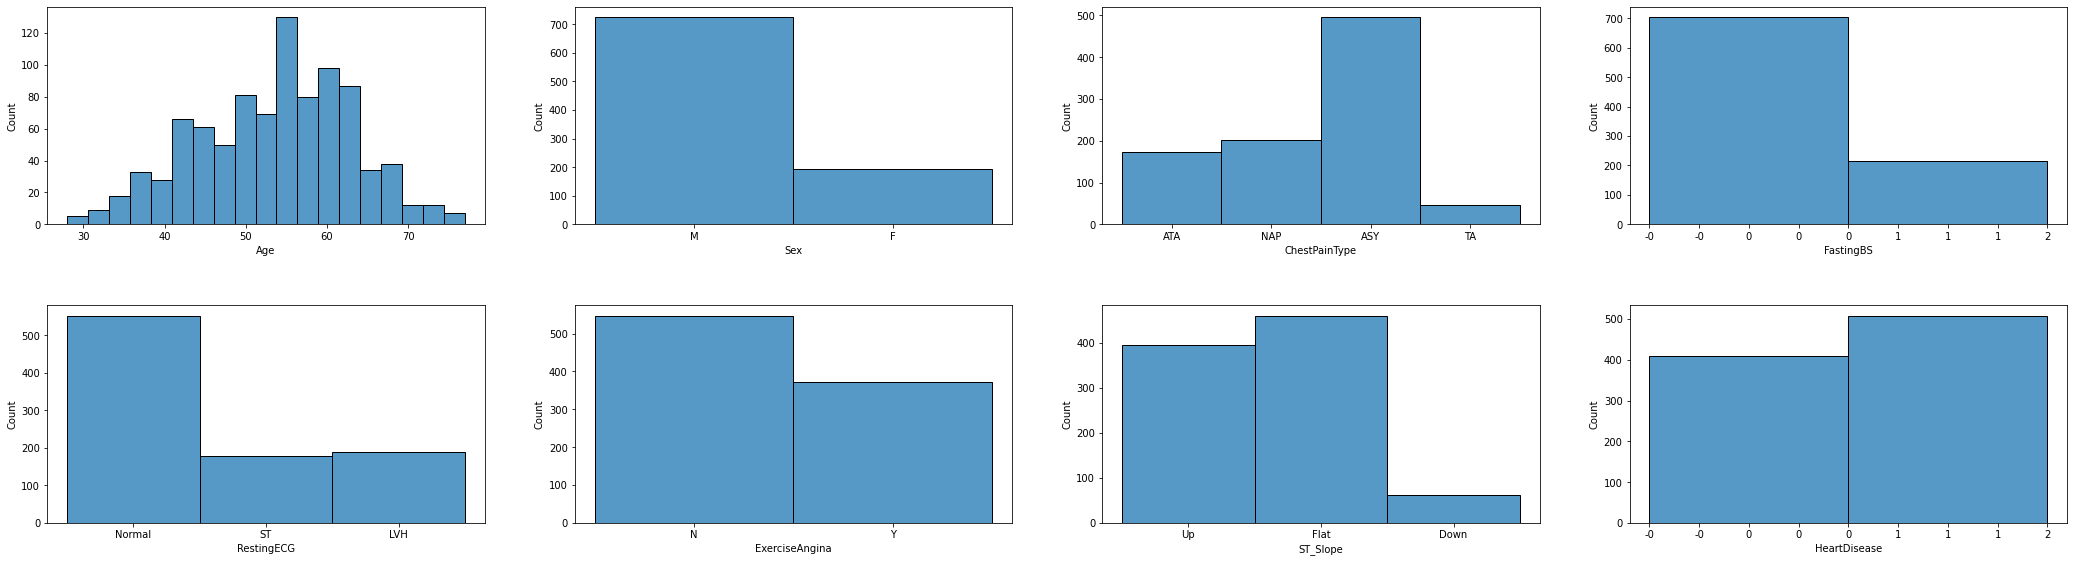

In [ ]:
#Histograms on categorical variables

fig, axes = plt.subplots(2,4, figsize=(30,9))

sns.histplot(data=df,x='Age',ax=axes[0][0]);
sns.histplot(data=df,x='Sex',ax=axes[0][1]);
sns.histplot(data=df,x='ChestPainType',ax=axes[0][2],bins=np.arange(5)-0.5);

a = sns.histplot(data=df,x='FastingBS',ax=axes[0][3],bins=np.arange(3)-0.5);
xlabels = ['{:,.0f}'.format(x) for x in a.get_xticks()]
a.set_xticklabels(xlabels);

sns.histplot(data=df,x='RestingECG',ax=axes[1][0],bins=np.arange(4)-0.5);

sns.histplot(data=df,x='ExerciseAngina',ax=axes[1][1],bins=np.arange(3)-0.5);
sns.histplot(data=df,x='ST_Slope',ax=axes[1][2],bins=np.arange(4)-0.5);
b = sns.histplot(data=df,x='HeartDisease',ax=axes[1][3],bins=np.arange(3)-0.5);
xlabels = ['{:,.0f}'.format(x) for x in b.get_xticks()]
b.set_xticklabels(xlabels);

fig.tight_layout(pad=5.0)

#Most people in this study are 40 to 70 years of age and Male.
#The dataset is mostly balanced, with more people having HeartDisease versus not.


In [ ]:
#Fasting BS should really be OHE, your readings will be different but one is not more intense/severe than the other so changing numbers to text to do OHE
df['FastingBS'].replace({1:'Fasting', 0:'Non-Fasting'}, inplace=True)

#If you have ExerciseAngina that's bad, so will ordinal encode
df['ExerciseAngina'].replace({'N':0, 'Y':1}, inplace=True)


#ChestPainType/ECG - these probably should be ordinal encoded as Normal/Asymptomatic seem better than the other conditions but I'm not a doctor so don't know which conditions are worse than each other so will one hot encode.
#Sex and ST_slope are more obvious candidates for one hot encoding


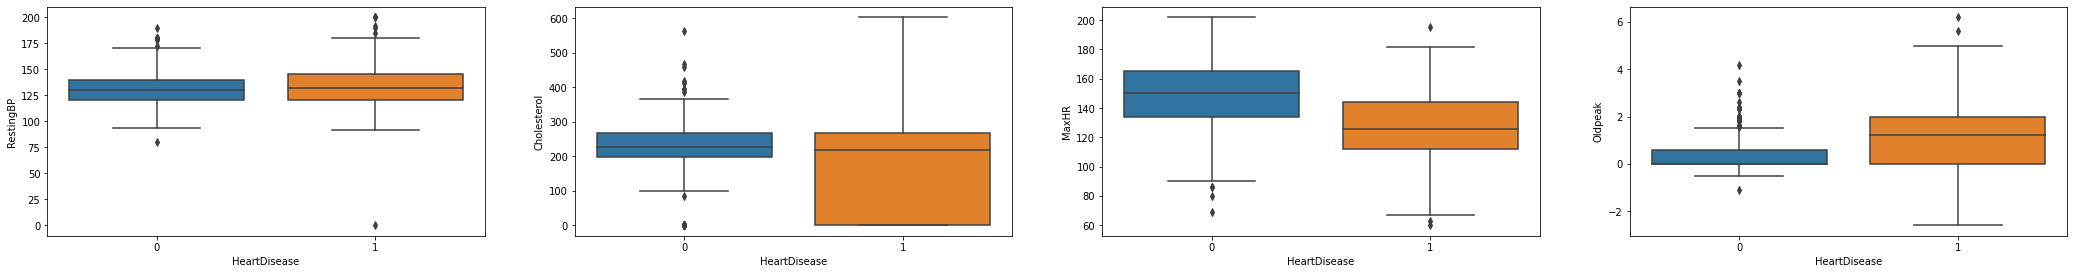

In [ ]:
#BP, Cholesterol, maxHR,old peak boxplots
fig, axes = plt.subplots(1,4, figsize=(30,5))
sns.boxplot(data = df, x='HeartDisease',y='RestingBP',ax=axes[0])
sns.boxplot(data = df, x='HeartDisease',y='Cholesterol',ax=axes[1])
sns.boxplot(data = df, x='HeartDisease',y='MaxHR',ax=axes[2])
sns.boxplot(data = df, x='HeartDisease',y='Oldpeak',ax=axes[3])

fig.tight_layout(pad=5.0)

#Those with Heart disease appear to have lower cholesterol, however there are a number of 0 values skewing this
#Those with Heart disease tend to have a lower MaxHR and higher/wider Oldpeak values.

In [ ]:
#good resting BP is 120 mm Hg systolic/80 mm Hg diastolic at most.
#LDL is bad, should be less than 200. HDL is good, 40 or above
#The 0 values for BP/Cholesterol need to be imputed

#df.loc[df['RestingBP']==0]
#df.loc[df['Cholesterol'] ==0]


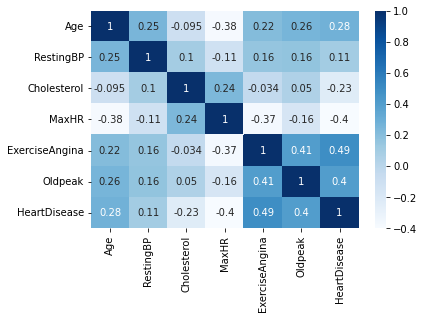

In [ ]:
#variables don't show strong correlation with one another
#fig, ax = plt.subplots(figsize=(10,10))
corr = df.corr()
sns.heatmap(corr,cmap='Blues',annot=True)

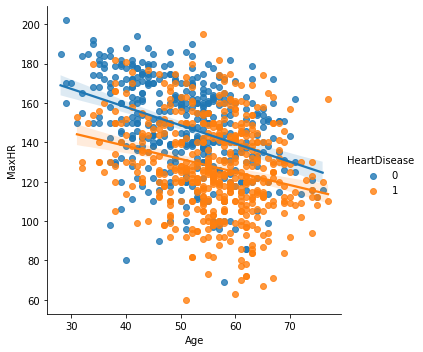

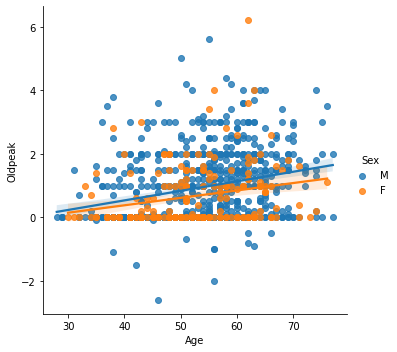

In [ ]:
#Age appears to be negatively correlated with MaxHR. The MaxHR for someone with Heart Disease is lower, all else equal.
#Old peak appears to increase with Age.This relationship holds for both Male and Females, with Males typically having higher Oldpeak values.

sns.lmplot(data = df,x = 'Age',y = 'MaxHR',hue ='HeartDisease')
sns.lmplot(data = df,x = 'Age',y = 'Oldpeak',hue ='Sex')

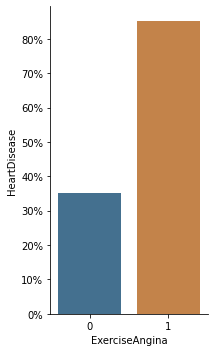

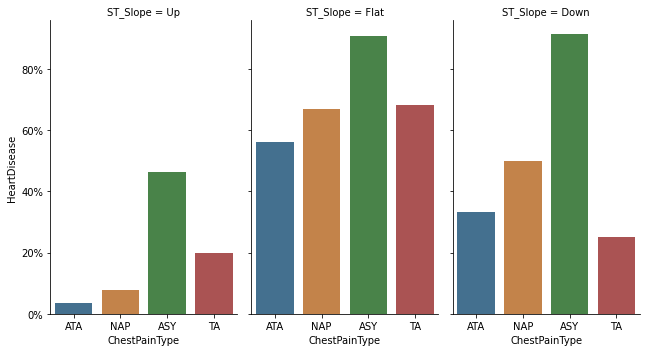

In [ ]:
#ExerciseAngina is a strong indiciator of Heart Disease. When this condition is present, it is highly indicative of Heart Disease as well.
#ST_Slope values of Flat/Down are more telling in terms of Heart Disease, as well as ChestPainType of ASY.

g = sns.catplot(x="ExerciseAngina", y="HeartDisease", data=df, saturation=.5, kind="bar", ci=None, aspect=.6)

#https://stackoverflow.com/questions/52512790/python-seaborn-catplot-how-do-i-change-the-y-axis-scale-to-percentage

for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

h = sns.catplot(x="ChestPainType", y="HeartDisease", col="ST_Slope",
                 data=df, saturation=.5,
                 kind="bar", ci=None, aspect=.6)

for ax in h.axes.flat:
    ax.yaxis.set_major_formatter(PercentFormatter(1))


In [ ]:
X = df.drop(columns='HeartDisease')
y = df['HeartDisease']

In [ ]:
#Split data into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [ ]:
#For Oldpeak and FastingBS - 0 values are appropriate
#Impute 0s to mean for BP and cholesterol as those values are not appropriate

#https://stackoverflow.com/questions/59424801/replacing-rows-having-0-to-mean-of-the-column

print(X_train['RestingBP'].mean())
print(X_train['Cholesterol'].mean())



bp_chol_imputer = SimpleImputer(missing_values=0,strategy='mean')

c = ['RestingBP','Cholesterol']
X_train[c] = bp_chol_imputer.fit_transform(X_train[c])

print('\n')
print('New means after imputing:')
print('\n')
print(X_train['RestingBP'].mean())
print(X_train['Cholesterol'].mean())

133.07703488372093
201.63662790697674


New means after imputing:


133.27074235807862
245.968085106383


In [ ]:
#Create preprocessing pipeline. 
#Imputing values based on histogram output above
#Ordinal encoding has already been applied in previous steps, so applying Scaling and one hot encoding here

cat_columns = make_column_selector(dtype_include='object')
num_columns = make_column_selector(dtype_include='number')

mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = StandardScaler()


num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

cat_tuple = (cat_pipe, cat_columns)
num_tuple = (num_pipe, num_columns)

preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa70eba2390>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa70eba2450>)])

In [ ]:
#quick check of processed data
X_train_processed = preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)


print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)


0 missing values in training data
0 missing values in testing data


Shape of X_train: (688, 11)
Shape of X_test: (230, 11)


All data in X_train_processed are float64
All data in X_test_processed are float64
